In [1]:
import joblib
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler

import shap
shap.initjs()

# SHAP on Logistic Regression

{'scaler': StandardScaler(), 'lr': LogisticRegression(random_state=42)}
(32710, 54) (32710,) (9000, 54) (9000,)


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


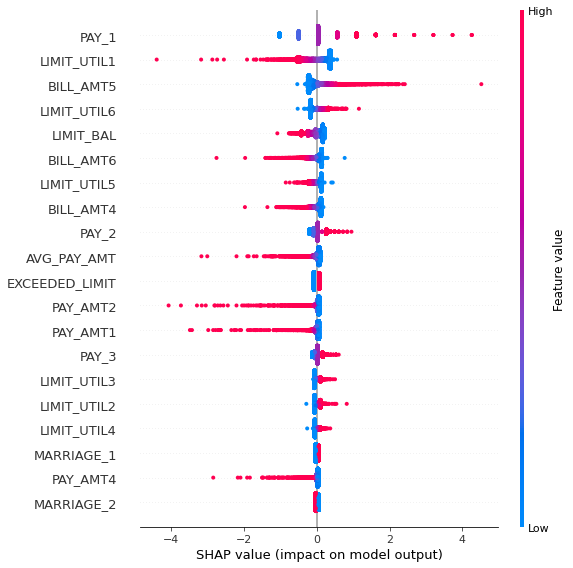

In [104]:
lr_train = pd.read_csv(r'Data/lr_train.csv')
lr_test = pd.read_csv(r'Data/lr_test.csv')
lr_pipe = joblib.load(r'logreg.sav')

print(lr_pipe.named_steps)

X_train = lr_train.drop(columns='default.payment.next.month')
y_train = lr_train['default.payment.next.month']
X_test = lr_test.drop(columns='default.payment.next.month')
y_test = lr_test['default.payment.next.month']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

scaler = StandardScaler()
scaler.fit(X_train)
X_test = scaler.transform(X_test)

explainer = shap.LinearExplainer(lr_pipe.named_steps['lr'], X_test)
shap_values = explainer.shap_values(X_test)

# Row 3637 was removed as it was an outlier in PAY_AMT2
shap.summary_plot(np.delete(shap_values, 3637, axis=0), 
                  features=np.delete(X_test, 3637, axis=0),
                  feature_names=X_train.columns)

## Manual calculation of SHAP averages to get ranked importance

In [105]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(20)

,col_name,feature_importance_vals
1,PAY_1,0.398480
39,LIMIT_UTIL1,0.327537
11,BILL_AMT5,0.221027
49,LIMIT_UTIL6,0.150623
0,LIMIT_BAL,0.140883
12,BILL_AMT6,0.130045
47,LIMIT_UTIL5,0.108749
10,BILL_AMT4,0.108128
2,PAY_2,0.098168
38,AVG_PAY_AMT,0.085056


## Explaining for distribution difference between EXCEEDED_LIMIT and PAY_AMT2

0.07552890517341374


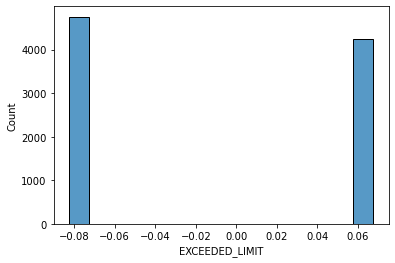

In [106]:
shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
sns.histplot(x=shap_df.EXCEEDED_LIMIT)
print(np.abs(shap_df.EXCEEDED_LIMIT).mean())

0.0665675577834329


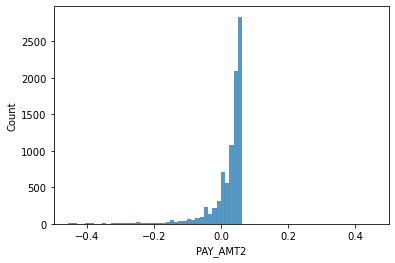

In [107]:
sns.histplot(x=shap_df.PAY_AMT2, bins=1000)
plt.xlim(-0.5, 0.5)
print(np.abs(shap_df.PAY_AMT2).mean())

# SHAP on Random Forest

{'scaler': StandardScaler(), 'rf': RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=4,
                       random_state=7)}
(32710, 54) (32710, 1) (9000, 54) (9000, 1)


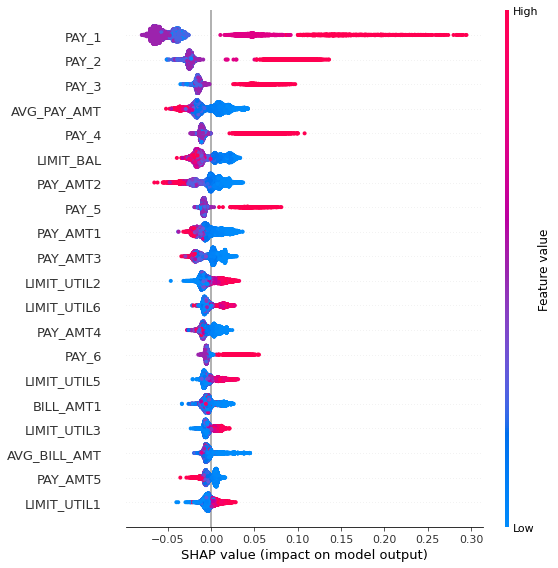

In [6]:
rf_train = pd.read_csv(r'Data/rf_train.csv')
rf_test = pd.read_csv(r'Data/rf_test.csv')
rf_pipe = joblib.load(r'rf.sav')

print(rf_pipe.named_steps)

X_train = rf_train.drop(columns='default.payment.next.month')
y_train = rf_train[['default.payment.next.month']]
X_test = rf_test.drop(columns='default.payment.next.month')
y_test = rf_test[['default.payment.next.month']]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

scaler = StandardScaler()
scaler.fit(X_train)
X_test = scaler.transform(X_test)

explainer = shap.TreeExplainer(rf_pipe.named_steps['rf'])
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], features=X_test, feature_names=X_train.columns)

In [7]:
vals= np.abs(shap_values[1]).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(5)

,col_name,feature_importance_vals
1,PAY_1,0.063821
2,PAY_2,0.034130
3,PAY_3,0.020420
38,AVG_PAY_AMT,0.016134
4,PAY_4,0.015301


# SHAP on XGBoost

{'scaler': StandardScaler(), 'xgb': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=2.212626851837828,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.022713751443330703, max_delta_step=0, max_depth=8,
              min_child_weight=1, min_child_weights=1.8717298505312536,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0.0190204198581071, reg_lambda=0.0927534352370206,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)}
(21000, 54) (21000,) (9000, 54) (9000,)


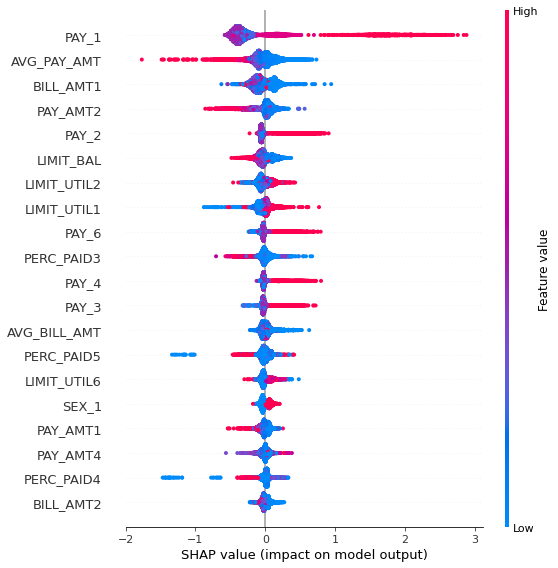

In [8]:
xgb_train = pd.read_csv(r'Data/cc_train.csv')
xgb_test = pd.read_csv(r'Data/cc_test.csv')
xgb_pipe = joblib.load(r'xgb.sav')

print(xgb_pipe.named_steps)

X_train = xgb_train.drop(columns='default.payment.next.month')
y_train = xgb_train['default.payment.next.month']
X_test = xgb_test.drop(columns='default.payment.next.month')
y_test = xgb_test['default.payment.next.month']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

scaler = StandardScaler()
scaler.fit(X_train)
X_test = scaler.transform(X_test)

explainer = shap.TreeExplainer(xgb_pipe.named_steps['xgb'])
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, features=X_test, feature_names=X_train.columns)

In [9]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(5)

,col_name,feature_importance_vals
1,PAY_1,0.482800
38,AVG_PAY_AMT,0.139020
7,BILL_AMT1,0.117596
14,PAY_AMT2,0.104883
2,PAY_2,0.104642
